In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = Path('/content/drive/MyDrive/currencydatasetfnf/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [ ]:
test_dir = Path('/content/drive/MyDrive/currencydatasetfnf/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
val_dir = Path('/content/drive/MyDrive/currencydatasetfnf/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [ ]:
# Image processing function to create DataFrame with filepaths and labels
def image_processing(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df[df['Label'] != 'train']  # Remove 'train' label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
# Process the datasets
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
# Display dataset details
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1223

Number of different labels: 20

Labels: ['1000 rupees' '20 rupees' '5000 rupees' '100 rupees' '2000 rupees indian'
 '500 rupees indian' '500 rupees' '20 rupees indian' '50 rupees indian'
 '50 rupees' '100 rupees indian' '500 saudi riyal' '10 rupees indian'
 '200 rupees indian' '5 saudi riyal' '100 saudi riyal' '10 saudi riyal'
 '10 rupees' '1 saudi riyal' '50 saudi riyal']


In [ ]:
# Create a DataFrame with unique labels for visualization
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

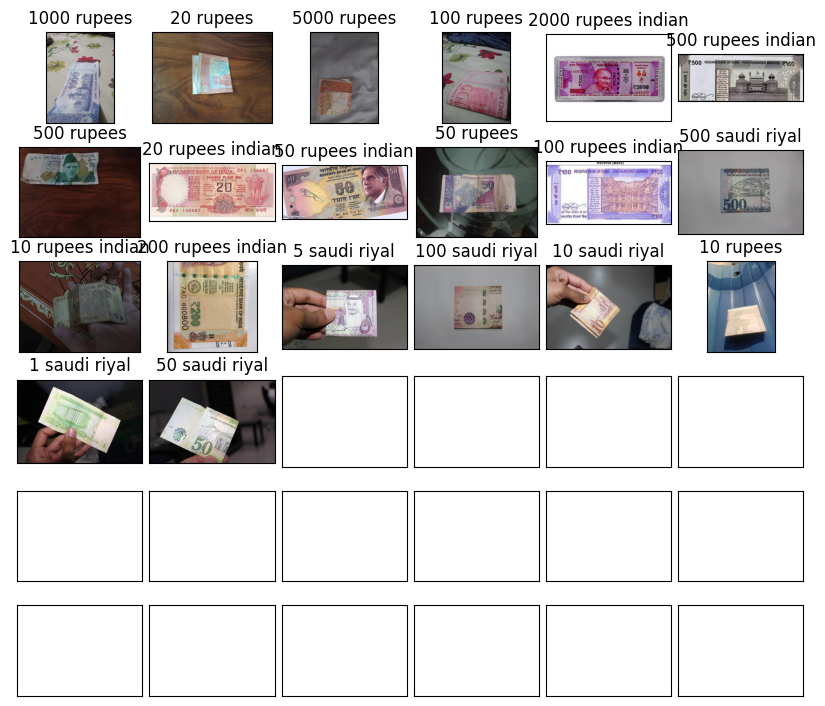

In [ ]:
# Display sample images
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    # Check if the index 'i' is within the bounds of the DataFrame
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        # If index is out of bounds, break the loop to avoid the error
        break
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Create image generators
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

Found 1223 validated image filenames belonging to 20 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

Found 328 validated image filenames belonging to 20 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 401 validated image filenames belonging to 20 classes.


In [ ]:
# Model setup with fine-tuning and additional layers
num_classes = len(train_df.Label.unique())
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)  # Increased dense layer size
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Increased dense layer size
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Model training with EarlyStopping and Learning Rate Scheduling
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]

In [ ]:
# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,  # Increased epochs for better training
    batch_size=32,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1553s 40s/step - accuracy: 0.1260 - loss: 2.8893 - val_accuracy: 0.2043 - val_loss: 2.6039 - learning_rate: 1.0000e-04
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 765ms/step - accuracy: 0.4298 - loss: 1.9672 - val_accuracy: 0.3445 - val_loss: 2.0644 - learning_rate: 1.0000e-04
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 838ms/step - accuracy: 0.5910 - loss: 1.3678 - val_accuracy: 0.5030 - val_loss: 1.5956 - learning_rate: 1.0000e-04
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 763ms/step - accuracy: 0.7078 - loss: 0.9872 - val_accuracy: 0.6067 - val_loss: 1.2298 - learning_rate: 1.0000e-04
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 778ms/step - accuracy: 0.7713 - loss: 0.7517 - val_accuracy: 0.6280 - val_loss: 1.0510 - learning_rate: 1.0000e-04
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 789ms/step - accuracy: 0.8497 - loss: 0.5199 - val_accuracy: 0.6463 - val_loss: 0.9539 - learning_rate: 1.0000e-04
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 867ms/step - acc

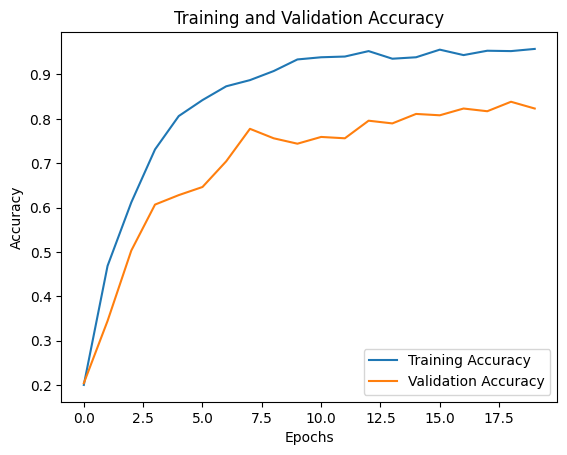

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# Print final accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")


Final Training Accuracy: 0.9574816226959229
Final Validation Accuracy: 0.8231707215309143


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

13/13 ━━━━━━━━━━━━━━━━━━━━ 351s 29s/step


['10 rupees indian',
 '20 rupees',
 '1000 rupees',
 '20 rupees indian',
 '500 rupees',
 '2000 rupees indian',
 '20 rupees indian',
 '500 rupees indian',
 '1000 rupees',
 '20 rupees',
 '2000 rupees indian',
 '10 saudi riyal',
 '2000 rupees indian',
 '5000 rupees',
 '20 rupees',
 '50 saudi riyal',
 '50 rupees',
 '5000 rupees',
 '20 rupees',
 '20 rupees',
 '50 saudi riyal',
 '500 rupees indian',
 '5000 rupees',
 '100 rupees',
 '1 saudi riyal',
 '500 rupees',
 '50 rupees',
 '1000 rupees',
 '10 rupees indian',
 '1000 rupees',
 '100 rupees indian',
 '1 saudi riyal',
 '50 rupees indian',
 '20 rupees',
 '500 rupees',
 '50 rupees',
 '10 rupees',
 '50 rupees indian',
 '200 rupees indian',
 '20 rupees indian',
 '20 rupees indian',
 '1000 rupees',
 '10 rupees',
 '5000 rupees',
 '50 rupees indian',
 '100 saudi riyal',
 '500 rupees',
 '100 rupees',
 '200 rupees indian',
 '20 rupees',
 '20 rupees indian',
 '100 rupees',
 '5000 rupees',
 '5000 rupees',
 '1000 rupees',
 '1000 rupees',
 '100 saudi riyal

In [ ]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/currency_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save the class labels to a text file
with open('/content/currency_labels.txt', 'w') as f:
    for label in labels.values():
        f.write(f"{label}\n")

# Download the TFLite model
from google.colab import files
files.download('/content/currency_model.tflite')

# Download the labels file
files.download('/content/currency_labels.txt')

Saved artifact at '/tmp/tmpw0gb6s46'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  133397470225680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470226448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470228176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470227792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470226640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470228368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470227408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470225296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470228560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133397470226256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1333974702289

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
img = output('/content/drive/MyDrive/currencydatasetfnf/test/100 rupees/IMG20211228220215.jpg')
print(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
100 rupees
